In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_parquet("DEF_dataset_24_25_persecond.parquet")

rename_map = {
    "DateTime": "DateTime",
    "Niveau O707": "tank_level",
    
    "Flow lijn A primair circuit": "flow_A_primary",
    "Flow lijn A totaal": "flow_A_total",
    "Flow lijn B primair circuit": "flow_B_primary",
    "Flow lijn B totaal": "flow_B_total",
    
    "Persdruk lijn A": "pressure_A_discharge",
    "Zuigdruk lijn A": "pressure_A_suction",
    "Uitsturing pomp lijn A": "output_A",
    
    "Persdruk lijn B": "pressure_B_discharge",
    "Zuigdruk lijn B": "pressure_B_suction",
    "Uitsturing pomp lijn B": "output_B",
    
    "Torque lijn A": "torque_A",
    "Torque lijn B": "torque_B",
    
    "Droge stof lijn 1": "drymatter_1",
    "Droge stof lijn 2": "drymatter_2",
    "Droge stof lijn 3": "drymatter_3",
    
    "Produktcode lijn1": "productcode_1",
    "Produktcode lijn2": "productcode_2",
    "Produktcode lijn3": "productcode_3"
}

df = df.rename(columns=rename_map)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.groupby(df.index).mean()


In [25]:
'''missingness plot (purple)
plt.figure(figsize=(14, 7))
sns.heatmap(df.isna().transpose(), cmap="viridis", cbar=False)
plt.title("Missingness matrix across variables")
plt.xlabel("Time")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()'''
print(df)

                     tank_level  flow_A_primary  flow_A_total  flow_B_primary  \
DateTime                                                                        
2024-09-04 11:36:38     2.43031         1.50981       2.94698         6.08584   
2024-09-04 11:37:38     2.43700         1.64095       3.10022         6.08572   
2024-09-04 11:38:38     2.45018         1.73062       3.22197         6.10668   
2024-09-04 11:39:38     2.46415         1.70921       3.22307         6.13646   
2024-09-04 11:40:38     2.47586         1.61467       3.13519         6.15684   
...                         ...             ...           ...             ...   
2025-09-12 15:09:38     2.56092         0.12152       0.97331         0.85591   
2025-09-12 15:10:38     2.55864         0.12152       0.94132         0.25408   
2025-09-12 15:11:38     2.55731         0.12152       0.95486         0.12496   
2025-09-12 15:12:38     2.53887         0.12152       0.95486         0.08493   
2025-09-12 15:13:38     2.53

In [26]:
#sets maximum of tank level to 4
df['tank_level'] = df['tank_level'].clip(upper=4)

In [27]:
#binary classified productcode columns!

product_cols = ['productcode_1','productcode_2','productcode_3']
df[product_cols] = df[product_cols].apply(lambda x: (x == 4).astype(int))

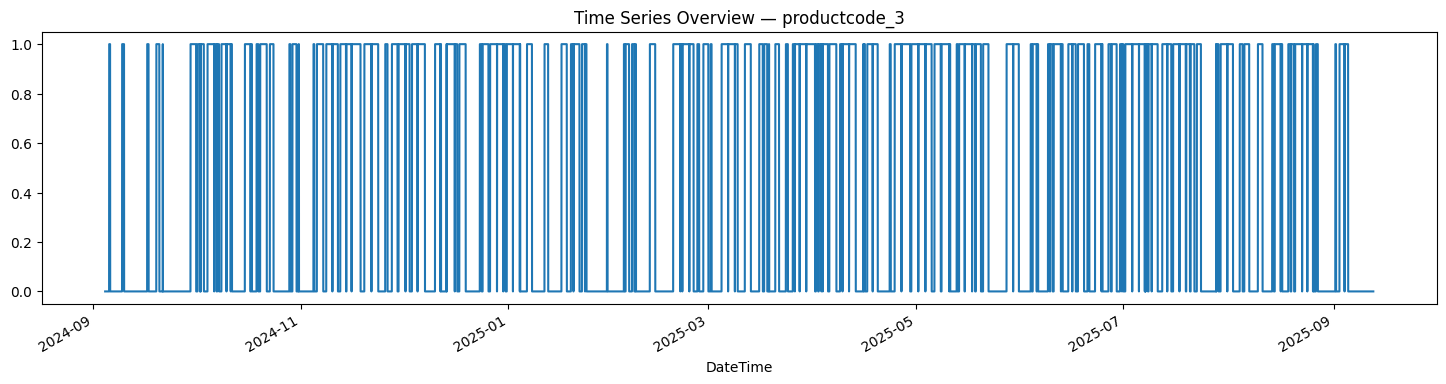

In [28]:
df['productcode_3'].plot(figsize=(18,4))
plt.title(f"Time Series Overview — productcode_3")
plt.xlabel("DateTime")
plt.show()

In [29]:
#dropping torque
torque_cols = ['torque_A', 'torque_B']
df = df.drop(columns=torque_cols)


In [30]:
# Replace negative values with NaN
dry_cols = ['drymatter_1', 'drymatter_2', 'drymatter_3']
df[dry_cols] = df[dry_cols].mask(df[dry_cols] < 0, np.nan)

In [31]:
# defining pump variabels (without Torque!)
pump_vars = [
    'flow_A_primary','flow_A_total','flow_B_primary','flow_B_total',
    'pressure_A_discharge','pressure_A_suction','output_A',
    'pressure_B_discharge','pressure_B_suction','output_B',
    'tank_level'
]
vars_to_impute = pump_vars + dry_cols

In [32]:
# identify downtime gaps 
dt = df.index.to_series().diff()
downtime_mask = dt > pd.Timedelta(minutes=10)

df = df.loc[~downtime_mask]

In [33]:
#rolling median imputation for short gaps
for col in vars_to_impute:
    df[col] = df[col].fillna(
        df[col].rolling('10min', min_periods=1).median()
    )

In [34]:
df.isna().mean().sort_values(ascending=False)


pressure_A_discharge    0.142037
output_B                0.104492
output_A                0.103844
tank_level              0.103837
pressure_A_suction      0.103412
pressure_B_discharge    0.103317
pressure_B_suction      0.103276
flow_B_primary          0.101463
flow_B_total            0.101462
flow_A_primary          0.101410
flow_A_total            0.101404
drymatter_3             0.078864
drymatter_1             0.029212
drymatter_2             0.017974
productcode_1           0.000000
productcode_2           0.000000
productcode_3           0.000000
dtype: float64

In [35]:
df.index.to_series().diff().max()


Timedelta('0 days 01:02:00')

In [36]:
df.isna().sum()


tank_level              55789
flow_A_primary          54485
flow_A_total            54482
flow_B_primary          54514
flow_B_total            54513
pressure_A_discharge    76313
output_A                55793
pressure_A_suction      55561
pressure_B_discharge    55510
output_B                56141
pressure_B_suction      55488
drymatter_1             15695
drymatter_2              9657
drymatter_3             42372
productcode_1               0
productcode_2               0
productcode_3               0
dtype: int64

In [37]:
for col in vars_to_impute:
    df[col] = df[col].fillna(
        df[col].rolling('10min', min_periods=1).median()
    )



In [38]:
df.isna().sum()

tank_level              55392
flow_A_primary          54062
flow_A_total            54074
flow_B_primary          54081
flow_B_total            54080
pressure_A_discharge    75948
output_A                55384
pressure_A_suction      55158
pressure_B_discharge    55096
output_B                55742
pressure_B_suction      55065
drymatter_1             14240
drymatter_2              8680
drymatter_3             40497
productcode_1               0
productcode_2               0
productcode_3               0
dtype: int64

In [39]:
#rewrite df_clean to a long format with pump_id variable.

def long_format(df):
    rows = []

    for pump in ['A', 'B']:
        rows.append(pd.DataFrame({
            'timestamp': df.index,
            'pump_id': pump,
            'suction': df[f'pressure_{pump}_suction'],
            'discharge': df[f'pressure_{pump}_discharge'],
            'output': df[f'output_{pump}'],
            'flow_primary': df[f'flow_{pump}_primary'],
            'flow_total': df[f'flow_{pump}_total'],
            # shared vars
            'tank_level': df['tank_level'],
            'drymatter_1': df['drymatter_1'],
            'drymatter_2': df['drymatter_2'],
            'drymatter_3': df['drymatter_3'],
            'productcode_1': df['productcode_1'],
            'productcode_2': df['productcode_2'],
            'productcode_3': df['productcode_3']
        }))

    df_long = pd.concat(rows).sort_values('timestamp').reset_index(drop=True)
    return df_long

df_long = long_format(df)


In [41]:
df_long.head(10)

,timestamp,pump_id,suction,discharge,output,flow_primary,flow_total,tank_level,drymatter_1,drymatter_2,drymatter_3,productcode_1,productcode_2,productcode_3
0,2024-09-04 11:36:38,A,1.51315,3.48480,14.45431,1.50981,2.94698,2.43031,58.90183,60.54215,58.76953,0,1,0
1,2024-09-04 11:36:38,B,1.20257,9.22907,68.72884,6.08584,13.04222,2.43031,58.90183,60.54215,58.76953,0,1,0
2,2024-09-04 11:37:38,B,1.20033,9.23295,68.72229,6.08572,13.03679,2.43700,58.90039,60.52592,58.77023,0,1,0
3,2024-09-04 11:37:38,A,1.50158,3.59583,15.31967,1.64095,3.10022,2.43700,58.90039,60.52592,58.77023,0,1,0
4,2024-09-04 11:38:38,A,1.49176,3.68986,15.91197,1.73062,3.22197,2.45018,58.90916,60.52657,58.77092,0,1,0
5,2024-09-04 11:38:38,B,1.19803,9.23740,68.71476,6.10668,13.03046,2.45018,58.90916,60.52657,58.77092,0,1,0
6,2024-09-04 11:39:38,A,1.49188,3.70084,15.95778,1.70921,3.22307,2.46415,58.89840,60.52838,58.77161,0,1,0
7,2024-09-04 11:39:38,B,1.19703,9.24185,68.70723,6.13646,13.02507,2.46415,58.89840,60.52838,58.77161,0,1,0
8,2024-09-04 11:40:38,A,1.49689,3.63501,15.44363,1.61467,3.13519,2.47586,58.90368,60.53019,58.77230,0,1,0
9,2024-09-04 11:40:38,B,1.19047,9.23956,68.69971,6.15684,13.01967,2.47586,58.90368,60.53019,58.77230,0,1,0


In [42]:

df = df_long.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

#safer mode function
def safe_mode(x):
    m = x.mode()
    if len(m) > 0:
        return m.iloc[0]
    return x.dropna().iloc[-1] if x.dropna().size > 0 else pd.NA

# pump-specific aggregation dictionary 
agg_dict = {
    'suction': 'mean',
    'discharge': 'mean',
    'output': 'mean',
    'flow_primary': 'mean',
    'flow_total': 'mean',
    'tank_level': 'mean',
    'drymatter_1': 'mean',
    'drymatter_2': 'mean',
    'drymatter_3': 'mean',
    'productcode_1': safe_mode,
    'productcode_2': safe_mode,
    'productcode_3': safe_mode,
}

# split pump id
df_A = df[df['pump_id'] == 'A'].set_index('timestamp')
df_B = df[df['pump_id'] == 'B'].set_index('timestamp')

# resample
A_10m = df_A.resample('10min').agg(agg_dict).assign(pump_id='A')
B_10m = df_B.resample('10min').agg(agg_dict).assign(pump_id='B')

# combine again
df_long_10m = (
    pd.concat([A_10m, B_10m])
      .sort_index()
      .reset_index()                 # timestamp back as column
)

df_long_10m.head()

,timestamp,suction,discharge,output,flow_primary,flow_total,tank_level,drymatter_1,drymatter_2,drymatter_3,productcode_1,productcode_2,productcode_3,pump_id
0,2024-09-04 11:30:00,1.499592,3.617833,15.410932,1.647647,3.123060,2.445410,58.902445,60.530755,58.770573,0,1,0,A
1,2024-09-04 11:30:00,1.199490,9.235318,68.718280,6.103675,13.033635,2.445410,58.902445,60.530755,58.770573,0,1,0,B
2,2024-09-04 11:40:00,1.532229,3.142893,12.059634,1.082256,2.446991,2.468781,58.917043,60.521769,58.791695,0,1,0,A
3,2024-09-04 11:40:00,1.171636,9.220241,68.665837,6.208184,13.010918,2.468781,58.917043,60.521769,58.791695,0,1,0,B
4,2024-09-04 11:50:00,1.533503,2.884417,10.512563,0.848890,2.144818,2.471946,58.922533,60.554102,58.790404,0,1,0,A


In [49]:
# Ensure timestamp is datetime
df_long_10m['timestamp'] = pd.to_datetime(df_long_10m['timestamp'])

# save to Parquet
df_long_10m.to_parquet("df_cleaned_resit.parquet", index=False)

print("Saved df_cleaned_resit.parquet successfully.")

Saved df_cleaned_resit.parquet successfully.


In [48]:
df_long_10m.isna().mean().sort_values(ascending=False)


discharge        0.121504
output           0.102912
tank_level       0.102633
suction          0.102066
flow_primary     0.100112
flow_total       0.100112
drymatter_3      0.072764
drymatter_1      0.024900
drymatter_2      0.015167
productcode_1    0.000112
productcode_2    0.000112
productcode_3    0.000112
timestamp        0.000000
pump_id          0.000000
dtype: float64